<a href="https://colab.research.google.com/github/Sandmorh/Paola.Moreno/blob/main/Moreno_Herrera_Sandra_Paola_Ejercicio_TM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Descarga de archivos de ProfNER
!wget https://zenodo.org/record/4563995/files/profner.zip?download=1
# Si el unzip no funciona, revisar cual es el nombre de descarga del archivo
!unzip  profner.zip?download=1

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: profner/subtask-1/test-background-txt-files/1243953060050763778.txt  
  inflating: profner/subtask-1/test-background-txt-files/1243988693947486209.txt  
  inflating: profner/subtask-1/test-background-txt-files/1244173600753618945.txt  
  inflating: profner/subtask-1/test-background-txt-files/1244319340062822405.txt  
  inflating: profner/subtask-1/test-background-txt-files/1247000104193712129.txt  
  inflating: profner/subtask-1/test-background-txt-files/1247263989249212416.txt  
  inflating: profner/subtask-1/test-background-txt-files/1247465550931988482.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249075777544556545.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249253729720766466.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249964965546668034.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249980196838682624.txt  
  inflating: profner/subta

Funciones de carga y preparación de datos

In [2]:
import nltk
import sys  
!{sys.executable} -m pip install contractions
!pip install spacy==3.2.1
!python -m spacy download en_core_web_sm
nltk.download('punkt')
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 11.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 659.5/659.5 kB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.1
    Uninstalling wasabi-1.1.1:
      Successfully uninstalled wasabi-1.1.1
  Attempting uninstall: typer
    Found existing installation: typer 0.7.0
    Uninstalling typer-0.7.0:
      Successfully uninstalled typer-0.7.0
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.7
    Uninstalling 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import sys
import os
import pandas as pd
def get_tweet_content(list_paths):
  """
    Función para guardar en un diccionario el contenido de archivos txt 
    que se introduce en su entrada. 
    Devuelve un diccionario en el que las claves son el id del tweet, y
    el valor el texto del tweet.
  """
  output_dict = dict()
  for i in list_paths:
    tweet_id = i.split("/")[-1].split(".txt")[0]
    with open(i) as f:
      output_dict[int(tweet_id)] = f.read()
  
  return output_dict

def get_profner_data(profner_path_data):
    # Obtenemos el path a los txt de los tweets.
    path_to_txt = profner_path_data+"subtask-1/train-valid-txt-files/"
    tweets_train_files = [path_to_txt+"train/"+i for i in os.listdir(path_to_txt+"train/")]
    tweets_valid_files = [path_to_txt+"valid/"+i for i in os.listdir(path_to_txt+"valid/")]
    # Obtenemos diccionarios en los que el key es el tweet_id y el value el texto del tweet.
    train_txt_content = get_tweet_content(tweets_train_files)
    valid_txt_content = get_tweet_content(tweets_valid_files)

    # Cargamos dos dataframes con los tweet_id y la categoría de los tweets
    path_to_labeled = profner_path_data+"subtask-1/"
    train_tweets = pd.read_csv(path_to_labeled+"train.tsv",sep="\t")
    valid_tweets = pd.read_csv(path_to_labeled+"valid.tsv",sep="\t")

    # Introducimos a los df el campo de texto mapeando los diccionarios con tweet_id
    train_tweets["tweet_text"] = train_tweets['tweet_id'].map(train_txt_content)
    train_tweets["set"] = "train"
    valid_tweets["tweet_text"] = valid_tweets['tweet_id'].map(valid_txt_content)
    valid_tweets["set"] = "valid"

    # Concatenamos el resultado
    output_df = pd.concat([train_tweets,valid_tweets],axis=0)
    # Eliminamos retorno de carro
    output_df["tweet_text"] = output_df.tweet_text.apply(lambda x: x.replace('\n', ' '))
    return output_df[["tweet_id","tweet_text","label","set"]].reset_index(drop=True)

  

# Ejercicio

En este ejercicio se trabajará con un conjunto de datos reales publicados para la shared-task [ProfNER](https://temu.bsc.es/smm4h-spanish/), celebrada en el año 2021. Específicamente, se utilizarán los datos textuales de la subtarea 1, centrada en la clasificación de textos. Este conjunto de datos son tweets en español que tienen asignada una etiqueta numérica, que representa la presencia (valor 1) o no (valor 0) de menciones de profesiones en el tweet. Por si fuera de tu interés, el proceso de obtención, selección y anotación de datos está descrita en [este enlace.](https://temu.bsc.es/smm4h-spanish/?p=4003).

Para el ejercicio debéis entrenar diferentes modelos de clasificación que permitan clasificar correctamente los tweets. Para ello será necesario crear y utilizar funciones de preprocesado de datos similares a las vistas en clase, aplicar estrategias de vectorización de trextos como TF-IDF o embeddings, y entrenar/evaluar modelos de clasificación. Para que os sirva de orientación, los criterios de evaluación del ejercicio serán los siguientes:

-	**Análisis exploratorio, pre-procesado y normalización de los datos (30%)**:
        -	El ejercicio deberá contener un análisis exploratorio de los datos como número de documentos, gráficas de distribución de longitudes y/o wordclouds, entre otros análisis que se os pudieran ocurrir. Vuestros ejercicios deberán incorporar al menos los análisis exploratorios vistos en clase.

    -	También tendréis que tener funciones para normalizar textos que permitan eliminar palabras vacías, quitar símbolos de puntuación y lematizar o hacer stemming.  

-	**Vectorización de textos (40%)**

    En clase hemos visto diferentes estrategias de vectorización como TF-IDF y Word Embeddings. También hemos visto como incorporar características adicionales utilizando el sentimiento de los documentos. Para este ejercicio sois libres de utilizar la estrategia de vectorización que queráis, pero:
  -	Si decidís utilizar TF-IDF será necesarios que incorporéis a modelo características adicionales de sentimiento utilizando recursos adicionales (como por ejemplo la librería TextBlob). 
  -	Si optáis por representar el texto mediante embeddings, dado que en clase no se profundizado sobre el tema no será necesario incorporar esas características adicionales. Si decidís esta segunda opción, podéis utilizar los embeddings en español que vimos en clase

-	**Entrenamiento y validación del sistema (30%)**
  -	En el proceso de entrenamiento del modelo tendréis que testear al menos 3 modelos de clasificación. El procedimiento debe ser similar al visto en clase, en el que primero estimábamos el rendimiento de varios algoritmos de forma general, para posteriormente seleccionar el mejor para ajustar los hiperparámetros.

## 0. Imports

In [4]:
!python -m spacy download es_core_news_sm
!pip install tweet-preprocessor
!pip install unidecode
!pip install emoji_extractor
!pip install emoji
!pip install pysentimiento
!pip install contractions
!pip install spacy
!pip install tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string 
import re 
import sys
import contractions 
import emoji
import string
import spacy


from wordcloud import WordCloud

from tqdm.autonotebook import tqdm
tqdm.pandas()

from tqdm import tqdm
nltk.download('punkt')
nltk.download('stopwords')


import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from tqdm.autonotebook import tqdm
tqdm.pandas()

from nltk.stem.snowball import SnowballStemmer

import preprocessor as p
from unidecode import unidecode
from emoji_extractor.extract import Extractor


from textblob import Word 
from tqdm.auto import tqdm
from tqdm.autonotebook import tqdm
tqdm.pandas()


!pip install nltk
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))

nltk.download('stopwords')

# para tratamiento tildes
!pip install unidecode
from unidecode import unidecode


# Pendientes:  import contractions  from tqdm.autonotebook import tqdm
#tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report



2023-05-25 10:06:45.889347: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 10:06:47.588240: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
DEPRECATION: https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-3.2.0/es_core_news_sm-3.2.0-py3-none-any.whl#egg=es_core_news_sm==3.2.0 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB

<ipython-input-4-8ada97519f28>:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `get_profner_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [5]:
profner_path = "./profner/"
datos_ejercicio = get_profner_data(profner_path)

In [6]:
datos_ejercicio.head(5)

,tweet_id,tweet_text,label,set
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train
4,1270421287148695556,Si el confinamiento ha dejado algo tocada tu e...,0,train


## 2. Análisis exploratorio de los datos (EDA)

Vamos a proceder con la validación del número de tweets, las columnas, si tenemos vacios o duplicados y la distribución del dataset.
También vamos a realizar un histograma y validaremos algunos ejemplos de tweets.

In [7]:
print("Tenemos un conjunto de {} tweets".format(len(datos_ejercicio)))
print("El dataframe tiene {} columnas".format(datos_ejercicio.shape[1]))


Tenemos un conjunto de 8000 tweets
El dataframe tiene 4 columnas


In [8]:
print("Existen {} tweets duplicados".format(np.sum(datos_ejercicio.duplicated(subset=["tweet_text"]))))
# No se tiene tweets duplicados 

Existen 0 tweets duplicados


In [9]:
print("Hay {} valores vacíos en las tweets y {} valores vacíos en las etiquetas en los datos".format(np.sum(datos_ejercicio.isnull())[0],
                                                                                              np.sum(datos_ejercicio.isnull())[1]))

# No se tienen valores vacios

Hay 0 valores vacíos en las tweets y 0 valores vacíos en las etiquetas en los datos


In [10]:
# Número de elementos de cada clase de la parte de entrenamiento
datos_ejercicio[datos_ejercicio['set'] == 'train']["label"].value_counts()

# Vemos que esta desbalanceado, por lo que debemos proceder con el proceso de balanceo. 

0    4607
1    1393
Name: label, dtype: int64

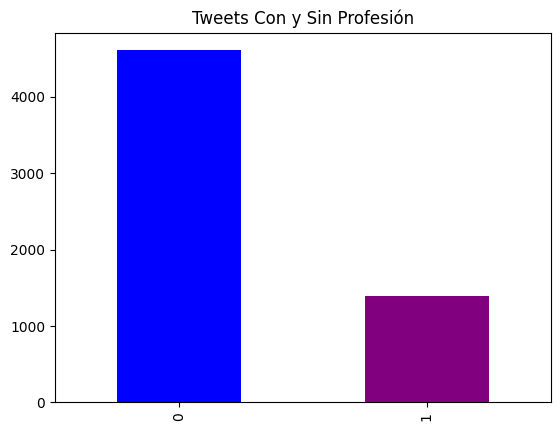

In [11]:
# vamos a proceder el histograma, aunque ya sabemos que no esta balanceado.

ax, fig = plt.subplots()
etiquetas = datos_ejercicio[datos_ejercicio['set'] == 'train']["label"].value_counts()
etiquetas.plot(kind= 'bar', color= ["blue", "purple"])
plt.title('Tweets Con y Sin Profesión')
plt.show()


Validar Contenido

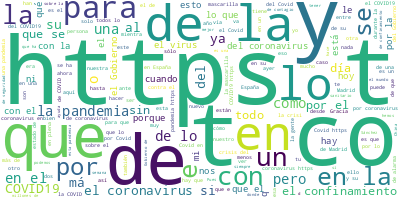

In [12]:
# Une las frases
long_string = ','.join(list(datos_ejercicio[datos_ejercicio['set'] == 'train']['tweet_text'].values))
# Genera un objecto WordCloud 
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0, contour_color='purpleblue')
# Genera el wordcloud
wordcloud.generate(long_string)
# Visualizalo en una imagen
wordcloud.to_image()

# Vamos referencias a la pandemia, virus, COVID y Coronavirus. el HTTPS nos indica que se mencionaban paginas WEB. Tenemos conectores 

Tweets con Mención de profesión

In [13]:
# Vamos a revisar algúnos de los tweets de cada tipo.

datos_ejercicio[datos_ejercicio.label==1].sample(3).tweet_text.to_list()

['@AntonioMaestre @lau_valero ¿Por qué le dejas el virus a tus padres en casa y tienen todo el tiempo que continúe activo para tocarlo y contagiarse? No lo sé, no soy médico, por eso no discuto vehementemente particularidades de un plan preparado por especialistas.',
 'Una novela intensa de principio a fin. Recorre las calles de Barcelona y descubre la terrible conspiración que llevará al doctor Nicolás Dalmau a vivir la experiencia más extraordinaria de su vida.  👉https://t.co/flVHeYbekQ Gratis en #KindleUnlimited  #yomequedoencasa #leeindie https://t.co/qZy1td2t8F',
 '¡Hoy,  siento vergüenza del Presidente de mi país! Espero dé explicaciones del motivo tan importante que  le ha impedido asistir al funeral de los fallecidos por la pandemia https://t.co/1mulrhgpPI']

Tweets Sin Mención de profesión

In [14]:
datos_ejercicio[datos_ejercicio.label==0].sample(3).tweet_text.to_list()

['🏛 @sanchezcastejon Llevamos 11 días de estado de alarma, volcados en mitigar el virus.  1⃣ Proteger a la población más expuesta 2⃣ Blindar el sistema de salud 3⃣ Proteger a la población  Medidas de máximo distanciamiento social para reducir contagios.  #EsteVirusLoParamosUnidos https://t.co/SQIIt5uJ70',
 'Casi 200 niños y niñas palestinos permanecen detenidos en cárceles israelíes, la mayoría a falta de juicio, en condiciones que no garantizan su protección contra el coronavirus. Nuestra compañera @clairenicoll conoce bien su historia y la relata aquí https://t.co/InszWYlTXu',
 '#ULTIMAHORA | La Generalitat ordena el confinamiento domiciliario en la ciudad de Lleida y otros siete municipios de su comarca por el rebrote de coronavirus.']

Distribución de la longitud de los tweets en caracteres:

<ipython-input-15-f0c402bcfb24>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt1 = sns.distplot(datos_ejercicio[datos_ejercicio["label"]==0].char_len, hist=True, label="Sin Profesión",color="blue")
<ipython-input-15-f0c402bcfb24>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt2 = sns.distplot(datos_ejercicio[da

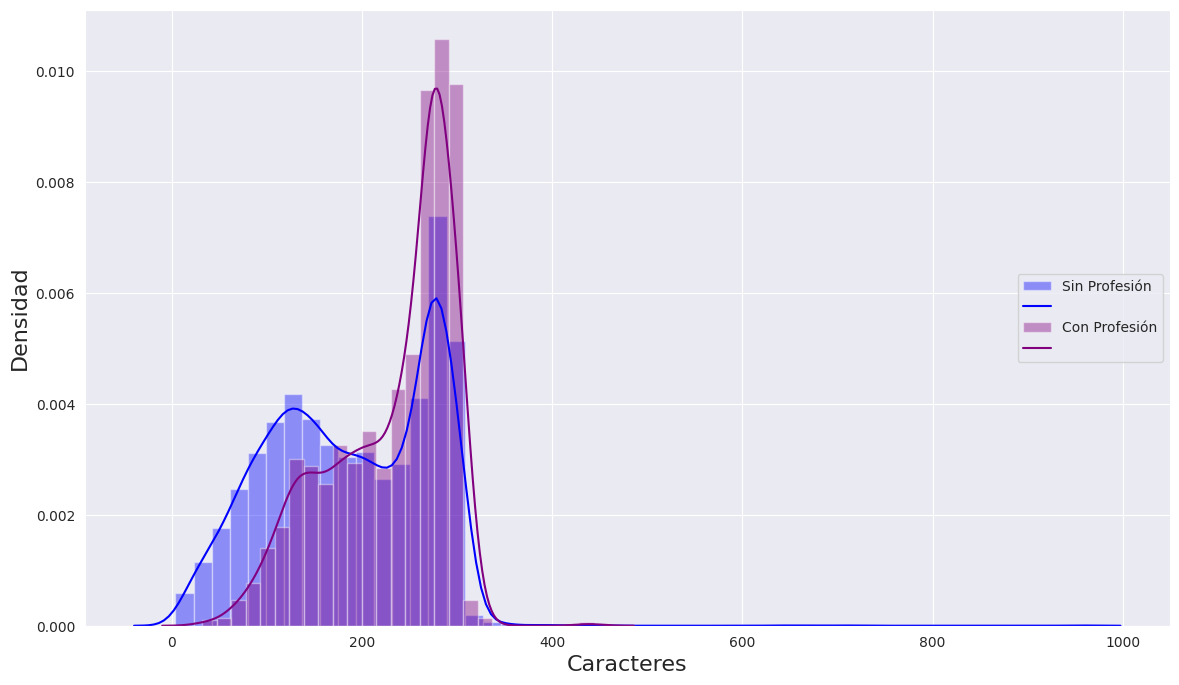

In [15]:
datos_ejercicio["char_len"] = datos_ejercicio["tweet_text"].apply(lambda x: len(x))

fig = plt.figure(figsize=(14,8))
sns.set_style("darkgrid")
# añadimos series para cada categoría (eligiendo la seríe de char_len
plt1 = sns.distplot(datos_ejercicio[datos_ejercicio["label"]==0].char_len, hist=True, label="Sin Profesión",color="blue")
plt2 = sns.distplot(datos_ejercicio[datos_ejercicio["label"]==1].char_len, hist=True, label="Con Profesión",color="purple")
plt.legend(labels=['Sin Profesión',"",'Con Profesión',""], loc = 5)

# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

los  tweets en los que se mencionan profesiones suelen tener una logitud un poco mayor a las que no tienen y la densidad es más alta pero no es deteminante para poder construir un clasificador.

Ahora vamos a ver la distribución para solo para la parte de train. 
* Primero separamos el dataset

In [16]:
datos_ejercicio['set'].value_counts()

train    6000
valid    2000
Name: set, dtype: int64

In [17]:
datos_ejercicio_train = datos_ejercicio[datos_ejercicio['set'] == 'train']
datos_ejercicio_test = datos_ejercicio[datos_ejercicio['set'] == 'valid']

<ipython-input-18-3225e1b6e086>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_ejercicio_train["char_len"] = datos_ejercicio_train["tweet_text"].apply(lambda x: len(x))
<ipython-input-18-3225e1b6e086>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt1 = sns.distplot(datos_ejercicio_train[datos_ejercicio_train["label"]==0].char_len, hist=True, label="Sin Profesión", color="blue")
<ipython-input-18-3225e1

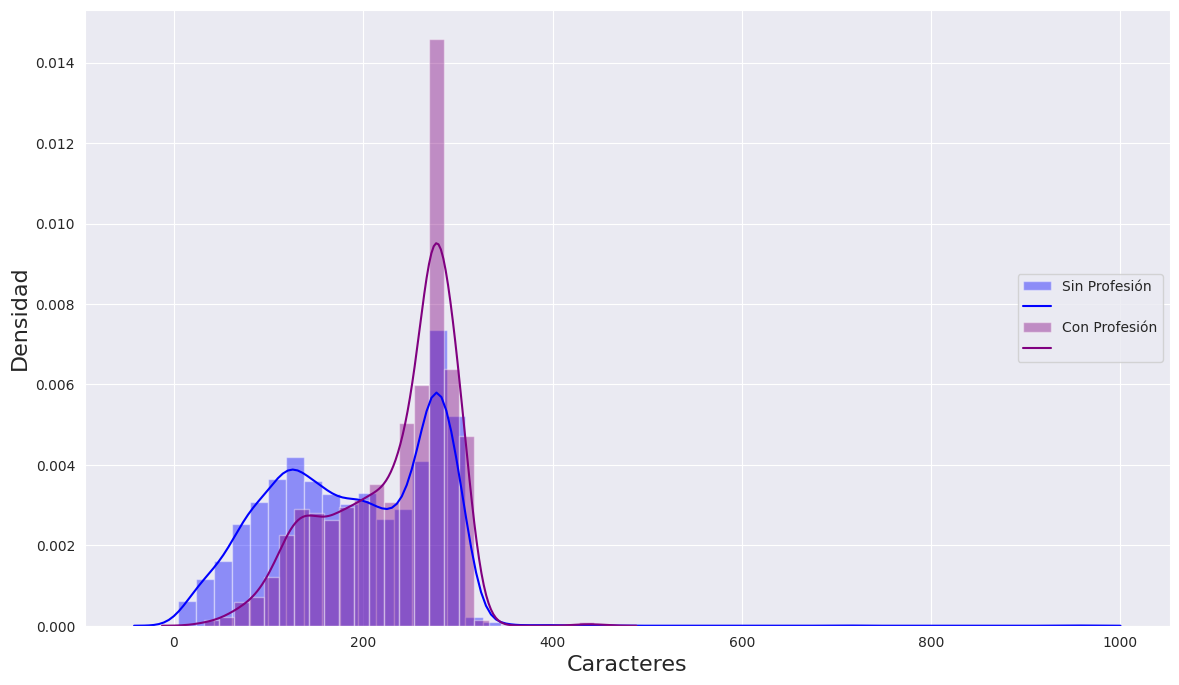

In [18]:
datos_ejercicio_train["char_len"] = datos_ejercicio_train["tweet_text"].apply(lambda x: len(x))

fig = plt.figure(figsize=(14,8))
sns.set_style("darkgrid")
# añadimos series para cada categoría (eligiendo la seríe de char_len
plt1 = sns.distplot(datos_ejercicio_train[datos_ejercicio_train["label"]==0].char_len, hist=True, label="Sin Profesión", color="blue")
plt2 = sns.distplot(datos_ejercicio_train[datos_ejercicio_train["label"]==1].char_len, hist=True, label="Con Profesión", color="purple")
plt.legend(labels=['Sin Profesión',"",'Con Profesión',""], loc = 5)

# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

## 3. Preprocesado y Normalización

Vamos a proceder a normalizar los datos. Para ello vamos a utilizar las funciones anteriormente definidas:

- Preprocesar los textos:
    
    - Tokenizaremos
    - Quitaremos stop words
    - Quitaremos puntuación
    - Lematizaremos ( No se puede usar WordNet por ser español)
    - Stemming 
    - En esta ocasión no extraeremos los emojis ni expanderemos las contracciones. 
    

Algoritmo de SnowballStemmer: Algoritmo de Stemming que soporta 13 lenguas en NLTK, incluyendo español. Es una versión mejorada del algoritmo de de Porter Stemming.

Preprocesamiento textos

In [19]:
# Eliminar espacios
def eliminar_espacios(text): 
    return  " ".join(text.split()) 

# To lower
def texto_to_lower(text):
  return text.lower()


from nltk.tokenize import TweetTokenizer
# Tokenizar los tweets con el tokenizador "TweetTokenizer" de NLTK
def tokenize(texto):
  tweet_tokenizer = TweetTokenizer()
  tokens = tweet_tokenizer.tokenize(texto)
  return tokens

# Quitar stop words
from nltk.corpus import stopwords
def quitar_stopwords(tokens):
    stop_words = set(stopwords.words('spanish')) 
    filtered_sentence = [w for w in tokens if not w in stop_words]
    return filtered_sentence


# Eliminar signos de puntuación (nos quedamos sólo lo alfanumérico en este caso)
def quitar_puntuacion(tokens):
    words=[word for word in tokens if word.isalnum()]
    return words


# Lemmatization

nlp = spacy.load("es_core_news_sm")
def lematizar(tokens):
    sentence = " ".join(tokens)
    mytokens = nlp(sentence)
    # Lematizamos los tokens y los convertimos  a minusculas
    mytokens = [ word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Extraemos el text en una string
    return " ".join(mytokens)

stemmer = SnowballStemmer(language="spanish")
def stem(tokens):
    tokens = [ stemmer.stem(token) for token in tokens]
    return tokens

/usr/local/lib/python3.10/dist-packages/spacy/util.py:887: UserWarning: [W095] Model 'es_core_news_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.5.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Preprocesamiento Tweets

In [20]:
def preprocess_tweets(sentence):
  #elimina espacios
  sentence = eliminar_espacios(sentence)
  #convierte a minusculas
  sentence= texto_to_lower(sentence)
 
  # Tokenizar
  sentence=  tokenize(sentence)
  #Quitar Stopwords
  sentence = quitar_stopwords(sentence)
  # Quitar puntuación
  sentence =  quitar_puntuacion(sentence)
 
  # Stemming
  #sentence = stem(sentence)
  # lematización (mediante spacy)
  sentence =  lematizar(sentence)
   # quitar tildes
  sentence = unidecode(sentence)
  return sentence

Extraemos sentimiento de los tweets

In [21]:
def extrae_emojis(texto):
  extract = Extractor()
  emojis = extract.count_emoji(texto, check_first=False)
  emojis_list = [key for key, _ in emojis.most_common()]
  #reemplazar los emojis por su descripcion 
  emojis_description = emoji.demojize( " ".join(emojis_list),language= 'es' )
  emojis_desc_final = emojis_description.replace(":","")
  emojis_desc_final = emojis_desc_final.replace("_"," ")

  emojis_blob = emojis_desc_final.split()
  emojis_lemmas = [Word(x).lemmatize("v") for x in emojis_blob]
  emojis_lemmas = " ".join(emojis_lemmas)
  return emojis_lemmas


In [22]:
emojis_train = datos_ejercicio_train["tweet_text"].apply(lambda x: extrae_emojis(x))
emojis_test = datos_ejercicio_test["tweet_text"].apply(lambda x: extrae_emojis(x))


datos_ejercicio_train['tweet_text'] = datos_ejercicio_train['tweet_text'].apply(lambda x: emoji.replace_emoji(x, ''))
datos_ejercicio_test['tweet_text'] = datos_ejercicio_test['tweet_text'].apply(lambda x: emoji.replace_emoji(x, ''))


# añadimos las  descripciones al dataset
datos_ejercicio_train["tweet_text"] = (datos_ejercicio_train["tweet_text"]+' '+emojis_train)
datos_ejercicio_test["tweet_text"] = (datos_ejercicio_test["tweet_text"]+' '+emojis_test)

<ipython-input-22-9150bcea3255>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_ejercicio_train['tweet_text'] = datos_ejercicio_train['tweet_text'].apply(lambda x: emoji.replace_emoji(x, ''))
<ipython-input-22-9150bcea3255>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_ejercicio_test['tweet_text'] = datos_ejercicio_test['tweet_text'].apply(lambda x: emoji.replace_emoji(x, ''))
<ipython-input-22-9150bcea3255>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [23]:
datos_ejercicio_normal = datos_ejercicio_train["tweet_text"].apply(lambda x: preprocess_tweets(sentence = x))

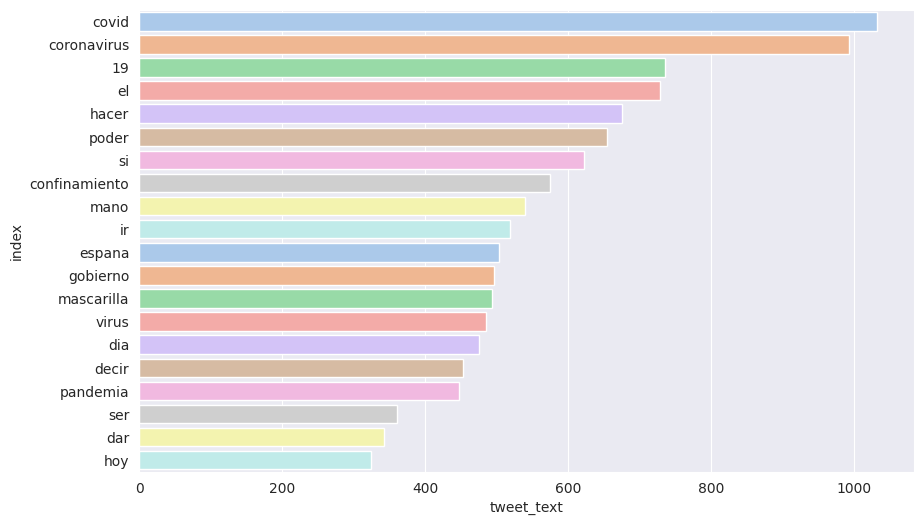

In [24]:
datos_ejercicio_normal = datos_ejercicio_normal.apply(lambda x: x.split(' '))
datos_ejercicio_normal= datos_ejercicio_normal.explode()

# Top 20 words with stopwords
plt.figure(figsize=(10, 6))
counts  = datos_ejercicio_normal.value_counts(ascending=False).reset_index().head(20)
sns.barplot(data = counts, y = 'index', x = 'tweet_text', orient= 'h', palette= 'pastel')
plt.show()

In [25]:
Xtrain = pd.DataFrame(datos_ejercicio_train["tweet_text"].progress_apply(lambda x: preprocess_tweets(sentence = x)))
Xtest = pd.DataFrame(datos_ejercicio_test["tweet_text"].progress_apply(lambda x: preprocess_tweets(sentence = x)))


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [26]:
Xtrain["token_len"] = Xtrain["tweet_text"].apply(lambda x: len(x))
Xtrain['label'] = datos_ejercicio_train['label']

Xtest["token_len"] = Xtest['tweet_text'].apply(lambda x: len(x))
Xtest['label'] = datos_ejercicio_test['label']

Xtrain.head()


,tweet_text,token_len,label
0,china libera pandemia liberar ovnis argentino ...,75,0
1,san francisco eeuu hacer 100 ano tras vivir pa...,57,0
2,porfi poneo mascarillar 28 nuevo cancion artis...,66,0
3,nuevo covid norma regla recibimiento comercio ...,139,0
4,si confinamiento dejado tocado estabilidad men...,106,0


<ipython-input-27-06a93399e9c6>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt1 = sns.distplot(Xtrain[Xtrain["label"]==0]["token_len"], hist=True, label="0", color="blue" )
<ipython-input-27-06a93399e9c6>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt1 = sns.distplot(Xtrain[Xtrain["label"]==1]["token_len"], h

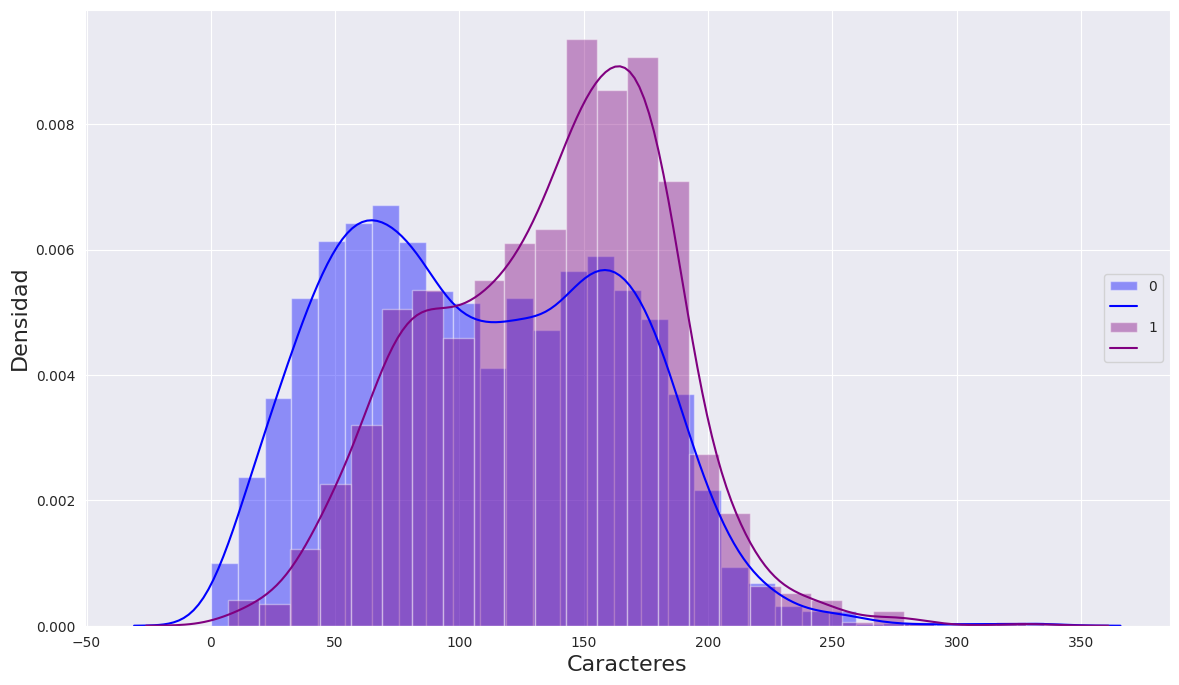

In [27]:
fig = plt.figure(figsize=(14,8))
sns.set_style("darkgrid")
plt1 = sns.distplot(Xtrain[Xtrain["label"]==0]["token_len"], hist=True, label="0", color="blue" )
plt1 = sns.distplot(Xtrain[Xtrain["label"]==1]["token_len"], hist=True, label="1", color="purple")

plt.legend(labels=['0',"",'1',""], loc = 5)

# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

plt.show()

Para español vamos a usar VADER Sentiment Analysis Multilanguage y para extraer sentimientos.


In [28]:
!pip install vader-multi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 6.2 MB/s eta 0:00:00


In [29]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [30]:
def get_sentiment_scores(tweet):
  scores = analyzer.polarity_scores(tweet)
  return pd.Series([scores['pos'], scores['neg'], scores['neu']])


In [31]:
# añadimos las nuevas columnas al dataframe

sentiment_scores = Xtrain['tweet_text'].apply(get_sentiment_scores)
sentiment_scores.columns = ['pos', 'neg', 'neu']
Xtrain = Xtrain.join(sentiment_scores)


Xtrain.head()

,tweet_text,token_len,label,pos,neg,neu
0,china libera pandemia liberar ovnis argentino ...,75,0,0.000,0.292,0.708
1,san francisco eeuu hacer 100 ano tras vivir pa...,57,0,0.000,0.000,1.000
2,porfi poneo mascarillar 28 nuevo cancion artis...,66,0,0.187,0.000,0.813
3,nuevo covid norma regla recibimiento comercio ...,139,0,0.000,0.000,1.000
4,si confinamiento dejado tocado estabilidad men...,106,0,0.233,0.139,0.628


In [32]:
from tqdm import tqdm
# Espacios
datos_ejercicio["normaliza"] = datos_ejercicio["tweet_text"].progress_apply(lambda x: eliminar_espacios(x))
# To Lower
datos_ejercicio["normaliza"] = datos_ejercicio["normaliza"].progress_apply(lambda x: texto_to_lower(x))
# Quitar Tildes
datos_ejercicio["normaliza"] = datos_ejercicio["normaliza"].progress_apply(lambda x: unidecode(x))
#Tokenizar
datos_ejercicio["normaliza"] = datos_ejercicio["normaliza"].progress_apply(lambda x: tokenize(x))
# Quitar Stopwords
datos_ejercicio["normaliza"] = datos_ejercicio["normaliza"].progress_apply(lambda x: quitar_stopwords(x))
# Quitar puntuación
datos_ejercicio["normaliza"] = datos_ejercicio["normaliza"].progress_apply(lambda x: quitar_puntuacion(x))
#Lematización
datos_ejercicio["normaliza"] = datos_ejercicio["normaliza"].progress_apply(lambda x: lematizar(x))

datos_ejercicio["normaliza"]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

0       china libera pandemia liberar ovnis argentino ...
1       san francisco eeuu hacer 100 ano tras vivir pa...
2       porfi poneo mascarillar 28 nuevo canción artis...
3       nuevo covid norma regla recibimiento comercio ...
4       si confinamiento dejado tocado estabilidad men...
                              ...                        
7995    nuevo infectado coronavirus multiplicar casi 2...
7996    ayuso adjudico dedo contrato euros hacer video...
7997    mes encerrado poder viajar provincia ir restau...
7998    gobierno prohibir ley lis despido crisis coron...
7999                              rasgo psicologico lleva
Name: normaliza, Length: 8000, dtype: object

Función de transformación que aglutinara todas las anteriores y pasársela al siguiente paso (TfidfVectorizer) en el campo analyzer. Para ver el proceso de cada uno de los pasos lo haremos paso a paso.


Como explicamos ayer, se ha hecho el preprocesado, y antes de introducirlo a TFIDF vamos a generar una frase de gada una de las listas de tokens, para utilizar el propio tokenizador de TFIDF.

In [33]:
datos_ejercicio["clean_text"] = datos_ejercicio["normaliza"].apply(lambda x: " ".join(x))

<ipython-input-34-0b9e06f819a3>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt1 = sns.distplot(datos_ejercicio[datos_ejercicio["label"]==0]["token_len"], hist=True, label="Sin", color="blue")
<ipython-input-34-0b9e06f819a3>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt2 = sns.distplot(datos_ejercicio[datos_e

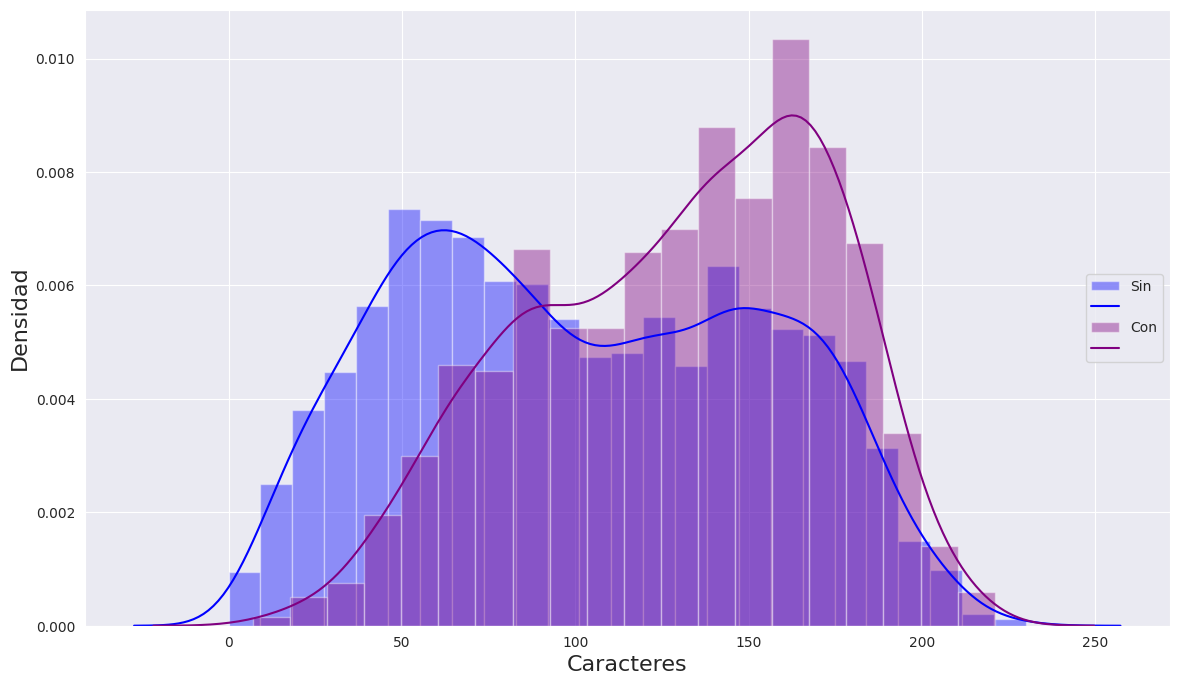

In [34]:
datos_ejercicio["token_len"] = datos_ejercicio["normaliza"].apply(lambda x: len(x))

fig = plt.figure(figsize=(14,8))
sns.set_style("darkgrid")
plt1 = sns.distplot(datos_ejercicio[datos_ejercicio["label"]==0]["token_len"], hist=True, label="Sin", color="blue")
plt2 = sns.distplot(datos_ejercicio[datos_ejercicio["label"]==1]["token_len"], hist=True, label="Con", color="purple")
plt.legend(labels=['Sin',"",'Con',""], loc = 5)

# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

plt.show()

## 4. Vectorización

In [35]:
vectorizador = TfidfVectorizer(lowercase = False, stop_words =None,
                               min_df=0.005, ngram_range = (1,3))

vector_data = vectorizador.fit_transform(Xtrain["tweet_text"])

In [36]:
import scipy as sp

#Unir las características TFIDF (contenidas en ´vector_data´) con las extrafeatures
extra_features = Xtrain[['pos','neg','neu', 'token_len']]

# Quitar las etiquetas y las asignamos a la variable y
y = Xtrain["label"].values.astype(np.float32) 


# Extraemos los valores (values) de las extra_features, que es un dataframe  
X = sp.sparse.hstack((vector_data,extra_features.values),format='csr')

In [37]:
X_columns=list(vectorizador.get_feature_names_out())+extra_features.columns.tolist()

Como vimos al inicio del EDA debemos efectuar el balanceo.

In [38]:
# Cargamos  
from imblearn.over_sampling import SMOTE 
# Creamos objetos
sm = SMOTE(random_state=99)
# Retransformamos
X_res, y_res = sm.fit_resample(X, y)
#X_res, y_res = sm.fit_resample(vector_data, Xtrain.label)

np.array(np.unique(y_res, return_counts=True)).T

array([[0.000e+00, 4.607e+03],
       [1.000e+00, 4.607e+03]])

# Entrenar/validar el clasificador:


Entramos ya en el apartado de entrenamiento del modelo. El primer paso es definir las variables predictoras, que son las características extraidas anteriormente a través de TF-IDF.

También especificaremos cual es la variable con las clases de cada documento.

In [39]:
# Importamos numpy:
import numpy as np

# Definimos la variable de categorías:
y = datos_ejercicio["label"].values.astype(np.float32) 

print(y.shape)
vector_data

(8000,)


<6000x561 sparse matrix of type '<class 'numpy.float64'>'
	with 51517 stored elements in Compressed Sparse Row format>

## 5. Entrenamiento y evaluación de modelos

In [40]:
# Definimos las funcionalidades pertinentes de sklearn:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings 
# Definimos la función encargada de evaluar los modelos:
def model_evaluation(models, score, X, y):
      results = []
      names = []
      #PAra cada modelo
      for name, model in models:
          warnings.filterwarnings('ignore') 
          # Generamos un Kfold
          KF = KFold(n_splits = 10, shuffle = True, random_state = 98)

          # hacemos croos_val
          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)
          
          # Guardamos los resultados:
          results.append(cv_results)
          names.append(name)
          
          # Mostramos los resultados numéricamente:
          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names

In [41]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# Definimos los modelos y generamos una lista con cada uno de ellos:
models = []
models.append(("Logistic", LogisticRegression(random_state=42)))
models.append(("RandomForest", RandomForestClassifier(n_estimators=70, max_depth=7, random_state=42)))
models.append(("DecisionTree", DecisionTreeClassifier(random_state=42)))


evaluation_score = "accuracy"

model_evaluation(models,  evaluation_score, X_res, y_res) 

Metric: accuracy , KFold 
Logistic: 0.772087 (0.012235) 
Metric: accuracy , KFold 
RandomForest: 0.810723 (0.008701) 
Metric: accuracy , KFold 
DecisionTree: 0.820384 (0.013004) 


([array([0.77982646, 0.7537961 , 0.78416486, 0.76355748, 0.77198697,
         0.78175896, 0.77307275, 0.78067318, 0.78393051, 0.74809989]),
  array([0.81995662, 0.79934924, 0.81778742, 0.80694143, 0.81216069,
         0.81324647, 0.82627579, 0.80456026, 0.80998914, 0.79695983]),
  array([0.84598698, 0.80911063, 0.81019523, 0.79934924, 0.82736156,
         0.82193268, 0.82627579, 0.82953312, 0.82627579, 0.80781759])],
 ['Logistic', 'RandomForest', 'DecisionTree'])

Observamos un mejor funcionamiento con los mejores. En el caso del  RandomForest debemos tener cuidado con un posible overfitting. 
*  VAmos a usar un Grid para validar los posibles parametros:

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Definimos el modelo DecisionTree
model = DecisionTreeClassifier(random_state=42)

# Definimos los parámetros a ajustar
param_grid = {
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5, 10]
}

# Realizamos la búsqueda de cuadrícula
grid_search = GridSearchCV(model, param_grid, scoring=evaluation_score, cv=5)
grid_search.fit(X_res, y_res)

# Imprimimos los resultados
print("Mejor modelo de DecisionTree encontrado:")
print(grid_search.best_estimator_)

Mejor modelo de DecisionTree encontrado:
DecisionTreeClassifier(max_depth=15, random_state=42)


Se realizo la prueba con los parametro recomendados, sin embargo tenemos un mejor resultado sin ajustar los parametros.

In [43]:
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
rf = DecisionTreeClassifier(random_state=42)

xtrain,xtest,ytrain,ytest = train_test_split(X_res,y_res)
rf.fit(xtrain,ytrain)
y_pred = rf.predict(xtest)
print(confusion_matrix(ytest,y_pred))
print(classification_report(ytest,y_pred))

[[884 274]
 [197 949]]
              precision    recall  f1-score   support

         0.0       0.82      0.76      0.79      1158
         1.0       0.78      0.83      0.80      1146

    accuracy                           0.80      2304
   macro avg       0.80      0.80      0.80      2304
weighted avg       0.80      0.80      0.80      2304



Matriz de confusión

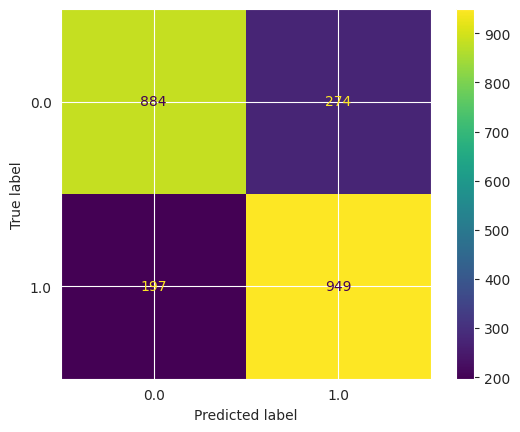

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(rf, xtest, ytest, normalize = None)

Variables

In [45]:
rf.fit(X_res,y_res)

df = pd.DataFrame({'feature': X_columns, 'importance': rf.feature_importances_})

df.sort_values('importance',ascending = False,inplace=True)

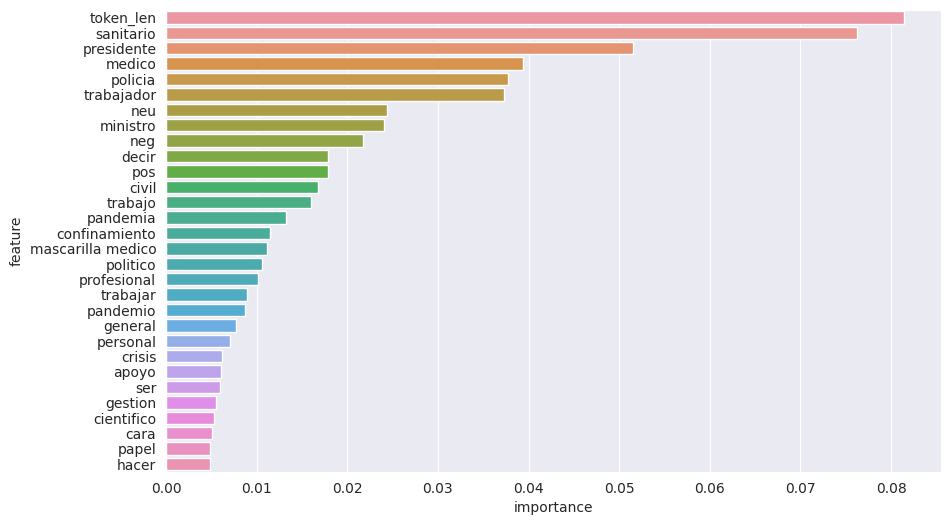

In [46]:
plt.figure(figsize=(10,6))
# cogemos sólo las más relevantes para que se vea el gráfico
sns.barplot(data = df.iloc[:30,:].sort_values('importance',ascending = False)
            , y = 'feature', x = 'importance' , orient = 'h')
plt.show()

Vemos que son palabras como santirario, presidentes, medico, policia, trabajo y ministro los más relevantes. 

In [47]:
sentiment_scores = Xtest['tweet_text'].apply(get_sentiment_scores)
sentiment_scores.columns = ['pos', 'neg', 'neu']
Xtest = Xtest.join(sentiment_scores)

extra_features_test = Xtest[['pos','neg','neu', 'token_len']]

In [48]:
vector_data_test = vectorizador.transform(Xtest["tweet_text"])
# y = Xtest["label"].values.astype(np.float32)
X = sp.sparse.hstack((vector_data_test,extra_features_test.values),format='csr')


rf.predict(X)


array([0., 0., 1., ..., 0., 0., 0.], dtype=float32)